In [1]:
%reload_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [25]:
from time import perf_counter

def format_time(seconds: float) -> str:
    """Convert seconds to MM:SS."""
    minutes, seconds = divmod(int(seconds), 60)
    return f"{int(minutes):02d}:{int(seconds):02d}"

# Dataset

First created in `01_Data_Aggregation.ipynb`. Deduplicated version generated in `03_Relevance_Dataset_Generation.ipynb`.

In [4]:
df = pd.read_csv('../data/processed_articles_dedup.csv')
len(df)

35292

In [5]:
df.head()

,docid,headline,body,website
0,64471158,Relaxed Marie Kondo Now Says She Perfectly Hap...,LOS ANGELES—Admitting that she'd made some maj...,The Onion
1,84486776,U.S. Officials Call For Correct Amount Of Viol...,WASHINGTON—Addressing the need for swift and m...,The Onion
2,36589089,Kamala Harris Asks Communications Assistant If...,WASHINGTON—In an effort to expand her professi...,The Onion
3,15387752,25 Arrested In Fake Nursing School Diploma Scheme,Federal agents have arrested 25 suspects accus...,The Onion
4,41114025,World's Oldest American Dies At 72,"OXNARD, CA—Living longer than any citizen in t...",The Onion


# Helper function

In [6]:
def predict_nsfw(text, tokenizer, model, device=device):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    model.to(device)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return probs.detach().cpu().numpy().squeeze()[1]  # select the +ve class only

# Sample some data

In [7]:
nsfw_words = ['slut', 'dildo', 'ejaculate']              
nsfw_df = df[df['body'].str.contains('|'.join(nsfw_words), case=False)]
len(nsfw_df)

54

In [8]:
# for r in nsfw_df.itertuples():
#     print(r.docid)
#     print(r.headline)
#     print(r.body)
#     print()

In [9]:
nsfw_examples = df[df.docid.isin([85171352, 70199327, 91608148, 56841622, 64333573, 21808507, 86786308])]
nsfw_examples[["docid", "headline"]]

,docid,headline
584,85171352,Grandmother Claims She Was Quite The Cum Dumps...
21378,86786308,Man Recalls Simpler Time When He Only Masturba...
22755,21808507,Ryan Chugs Down Rhino Horn And Bull Semen Shak...
26716,64333573,Sean O'Hair Gains Revenge By Angrily Masturbat...
29936,56841622,Loss Of Virginity More Humiliating Than Origin...
34081,91608148,'hot 'n' nasty butt cum chixx' to appear as 'c...
34486,70199327,We Asked 6 Porn Stars About Their Most Memorab...


In [10]:
# df.sample(5)

In [11]:
sfw_examples = df[df.docid.isin([64471158, 82535365, 16557897, 66510158, 98163715, 96362761, 33924507])]
sfw_examples[["docid", "headline"]]

,docid,headline
0,64471158,Relaxed Marie Kondo Now Says She Perfectly Hap...
2665,66510158,God Reveals Frogs' Mouths Designed Specificall...
13465,33924507,Posture Could Dictate Success In Online Dating
18431,98163715,Family Avoiding Eye Contact With Dad After Ste...
23575,82535365,Intel Ships Flawed Chip
31723,96362761,"Adult-Entertainment Industry Donates $100,000 ..."
32936,16557897,Perhaps I've Been A Little Too Tough On Crime


# 1. eliasalbouzidi/distilbert-nsfw-text-classifier

In [12]:
tokenizer = AutoTokenizer.from_pretrained("eliasalbouzidi/distilbert-nsfw-text-classifier", max_length=512)
model = AutoModelForSequenceClassification.from_pretrained("eliasalbouzidi/distilbert-nsfw-text-classifier")

In [13]:
predict_nsfw_1 = partial(predict_nsfw, tokenizer=tokenizer, model=model)

NSFW:

In [14]:
nsfw_1 = nsfw_examples.body.map(predict_nsfw_1)
nsfw_examples[["docid", "headline"]].assign(nsfw=nsfw_1)

,docid,headline,nsfw
584,85171352,Grandmother Claims She Was Quite The Cum Dumps...,0.876170
21378,86786308,Man Recalls Simpler Time When He Only Masturba...,0.009617
22755,21808507,Ryan Chugs Down Rhino Horn And Bull Semen Shak...,0.001231
26716,64333573,Sean O'Hair Gains Revenge By Angrily Masturbat...,0.933693
29936,56841622,Loss Of Virginity More Humiliating Than Origin...,0.914380
34081,91608148,'hot 'n' nasty butt cum chixx' to appear as 'c...,0.019548
34486,70199327,We Asked 6 Porn Stars About Their Most Memorab...,0.854760


- Some false negatives (docids 86786308, 21808507, 91608148 not detected)

SFW:

In [15]:
sfw_1 = sfw_examples.body.map(predict_nsfw_1)
sfw_examples[["docid", "headline"]].assign(nsfw=sfw_1)

,docid,headline,nsfw
0,64471158,Relaxed Marie Kondo Now Says She Perfectly Hap...,0.005760
2665,66510158,God Reveals Frogs' Mouths Designed Specificall...,0.051295
13465,33924507,Posture Could Dictate Success In Online Dating,0.001834
18431,98163715,Family Avoiding Eye Contact With Dad After Ste...,0.003717
23575,82535365,Intel Ships Flawed Chip,0.001087
31723,96362761,"Adult-Entertainment Industry Donates $100,000 ...",0.017852
32936,16557897,Perhaps I've Been A Little Too Tough On Crime,0.001173


- No false positives

# 2. michellejieli/NSFW_text_classifier

In [16]:
tokenizer = AutoTokenizer.from_pretrained("michellejieli/NSFW_text_classifier")
model = AutoModelForSequenceClassification.from_pretrained("michellejieli/NSFW_text_classifier")

In [17]:
predict_nsfw_2 = partial(predict_nsfw, tokenizer=tokenizer, model=model)

NSFW:

In [18]:
nsfw_2 = nsfw_examples.body.map(predict_nsfw_2)
nsfw_examples[["docid", "headline"]].assign(nsfw=nsfw_2)

,docid,headline,nsfw
584,85171352,Grandmother Claims She Was Quite The Cum Dumps...,0.940273
21378,86786308,Man Recalls Simpler Time When He Only Masturba...,0.935523
22755,21808507,Ryan Chugs Down Rhino Horn And Bull Semen Shak...,0.959215
26716,64333573,Sean O'Hair Gains Revenge By Angrily Masturbat...,0.964122
29936,56841622,Loss Of Virginity More Humiliating Than Origin...,0.952111
34081,91608148,'hot 'n' nasty butt cum chixx' to appear as 'c...,0.962567
34486,70199327,We Asked 6 Porn Stars About Their Most Memorab...,0.945642


- Detects all with high confidence

SFW:

In [19]:
sfw_2 = sfw_examples.body.map(predict_nsfw_2)
sfw_examples[["docid", "headline"]].assign(nsfw=sfw_2)

,docid,headline,nsfw
0,64471158,Relaxed Marie Kondo Now Says She Perfectly Hap...,0.918450
2665,66510158,God Reveals Frogs' Mouths Designed Specificall...,0.939796
13465,33924507,Posture Could Dictate Success In Online Dating,0.708150
18431,98163715,Family Avoiding Eye Contact With Dad After Ste...,0.962492
23575,82535365,Intel Ships Flawed Chip,0.232028
31723,96362761,"Adult-Entertainment Industry Donates $100,000 ...",0.952437
32936,16557897,Perhaps I've Been A Little Too Tough On Crime,0.706975


- Too many false positives

In [20]:
print(df.loc[18431].body)

BETHEL PARK, PA—Uncomfortably shifting in their seats as the costly turnover was replayed in slow motion, the entire Harrison family avoided eye contact with father Jeff Harrison for several incredibly tense minutes Sunday following a fumble by the Pittsburgh Steelers, household sources confirmed. "Goddammit," said the visibly incensed 52-year-old, who just moments before had been jovially watching the game with his wife and two children, all of whom were now in complete silence and actively staring straight ahead or down at their phones as the fumble was confirmed by referees. "C'mon—hang on to the ball for Christ's sake! Unbelievable." At press time, reports confirmed the two Harrison children were quietly considering leaving the room and watching the game upstairs as their father began to yell that the player's knee was down and that Steelers head coach Mike Tomlin should "just challenge the damn call."


In [21]:
print(df.loc[0].body)

LOS ANGELES—Admitting that she'd made some major lifestyle changes since developing her famous KonMari method, a relaxed Marie Kondo told reporters Tuesday that she was now perfectly happy living in waist-high sewage. "The truth is, while I used to be very hard on myself about keeping everything clean, I'm now able to find peace living my life half-submerged in a large, fetid pool of human waste," said Kondo, who added that while things like tidiness, organization, and minimalism used to spark joy for her, she now felt that same warmth from wading, floating, and swimming in the many gallons of untreated urine and feces that currently filled her home. "It was difficult, but once I had my children, I began to find it impossible to remove, clean, and sanitize the unending stream of excrement that bubbled up out of my toilets and filled my house to the point of collapse. While I used to hate it, I now see that each individual piece of human shit plays a part in creating a relaxed, easygoin

# Run on full dataset

Choose `eliasalbouzidi/distilbert-nsfw-text-classifier` as the final model as the other one gives too many false positives.

From the paper in which the model was trained [(DiffGuard: Text-Based Safety Checker for Diffusion Models)](https://arxiv.org/abs/2412.00064):
> We have created two versions of this model to balance
precision and recall according to different requirements. One
version is designed for a good equilibrium between precision
and recall, achieved by setting the threshold at 0.95. The other
version prioritizes high recall for critical applications, where
avoiding false negatives is crucial, even at the cost of some
false positives. This is achieved by setting the threshold at 0.8.

Based on the above and what we saw on our (limited) examples, we heuristically set a threshold of 0.7

In [38]:
NSFW_THRESH = 0.7

In [26]:
st_time = perf_counter()
prob_body = df.body.map(predict_nsfw_1)
print(f"Took {format_time(perf_counter() - st_time)}")

Took 03:06


In [27]:
st_time = perf_counter()
prob_hline = df.headline.map(predict_nsfw_1)
print(f"Took {format_time(perf_counter() - st_time)}")

Took 02:42


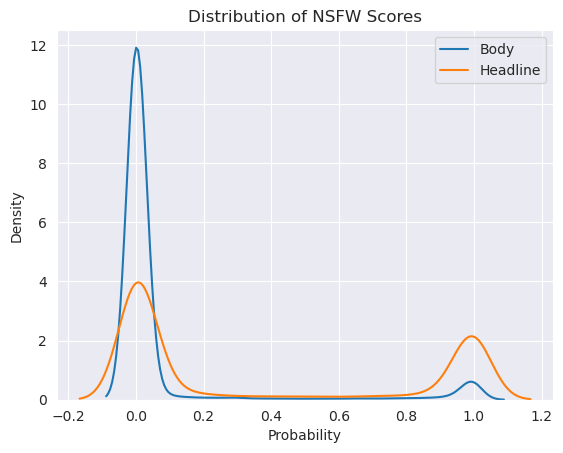

In [33]:
nsfw_scores = pd.DataFrame({"docid": df["docid"].values, "body": prob_body, "headline": prob_hline})

sns.set_style('darkgrid')
sns.kdeplot(nsfw_scores['body'], label='Body')
sns.kdeplot(nsfw_scores['headline'], label='Headline')
plt.legend()
plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Distribution of NSFW Scores')
plt.show()

In [34]:
nsfw_scores.head()

,docid,body,headline
0,64471158,0.005760,0.999894
1,84486776,0.002082,0.998990
2,36589089,0.000332,0.999910
3,15387752,0.005371,0.984198
4,41114025,0.000532,0.997546


In [35]:
nsfw_scores.to_csv("../data/nsfw_scores.csv", index=False)

Only use the score for article body:

In [39]:
df["nsfw_score"] = prob_body
df["nsfw"] = df["nsfw_score"] >= NSFW_THRESH

In [40]:
df.nsfw.value_counts()

nsfw
False    33053
True      2239
Name: count, dtype: int64

In [46]:
df.nsfw.value_counts(normalize=True)

nsfw
False    0.936558
True     0.063442
Name: proportion, dtype: float64

- About 6% of the articles are classified as NSFW.

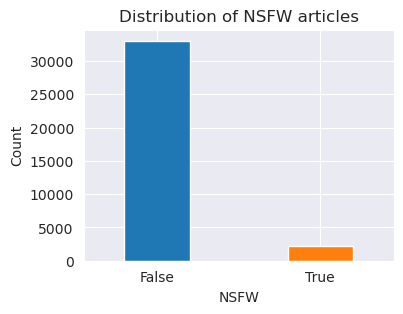

In [45]:
df.nsfw.value_counts().plot.bar(rot=0, color=sns.color_palette(), width=0.4, figsize=(4, 3))
plt.xlabel("NSFW")
plt.ylabel("Count")
plt.title("Distribution of NSFW articles")
plt.show()

In [48]:
df.head()

,docid,headline,body,website,nsfw_score,nsfw
0,64471158,Relaxed Marie Kondo Now Says She Perfectly Hap...,LOS ANGELES—Admitting that she'd made some maj...,The Onion,0.005760,False
1,84486776,U.S. Officials Call For Correct Amount Of Viol...,WASHINGTON—Addressing the need for swift and m...,The Onion,0.002082,False
2,36589089,Kamala Harris Asks Communications Assistant If...,WASHINGTON—In an effort to expand her professi...,The Onion,0.000332,False
3,15387752,25 Arrested In Fake Nursing School Diploma Scheme,Federal agents have arrested 25 suspects accus...,The Onion,0.005371,False
4,41114025,World's Oldest American Dies At 72,"OXNARD, CA—Living longer than any citizen in t...",The Onion,0.000532,False


In [49]:
df.to_csv("../data/processed_articles_dedup_nsfwtags.csv", index=False)

# Wordcloud

In [2]:
df = pd.read_csv("../data/processed_articles_dedup_nsfwtags.csv")

In [3]:
nsfw_df = df[df.nsfw]
len(nsfw_df)

2239

In [5]:
from itertools import chain

nsfw_text = " ".join(nsfw_df.body.str.lower().tolist())
nsfw_text += " ".join(nsfw_df.headline.str.lower().tolist())
len(nsfw_text.split())

326248

In [6]:
from src.utils import load_txt

stopwords = set(load_txt("../data/stopwords_updated.txt"))
len(stopwords)

550

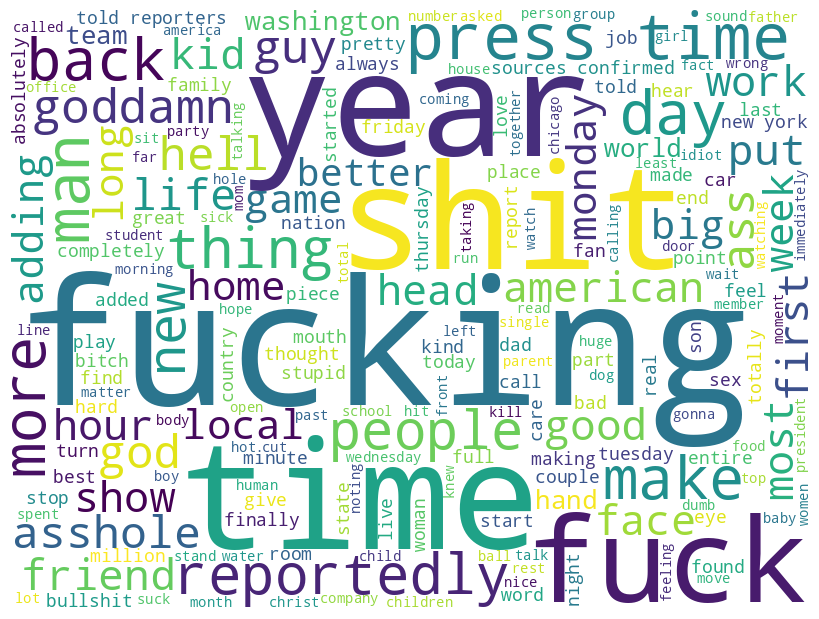

In [8]:
# Word cloud for the most common words in the articles
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=600, background_color ='white', 
                      regexp="\w[\w']+", stopwords=stopwords, min_font_size=10)

wordcloud.generate(nsfw_text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()